In [1]:
from tsutils import get_jena, WindowGenerator, compile_and_fit, split_data, nse_loss, split_data_2
import tensorflow as tf
from get_data import get_data

/bin/bash: /home/john/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Read Data

In [2]:
basin_3 = get_data("HUC_03_GAGEID_03488000")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [3]:
basin_3.head()

,Q.ft3.s.,dayl.s.,prcp.mm.day.,srad.W.m2.,tmax.C.,tmin.C.,vp.Pa.
1,269,34214.39,0.15,222.28,7.45,-0.70,586.27
2,245,34214.39,0.00,190.21,3.64,-2.89,493.86
3,218,34214.39,0.00,243.60,6.55,-2.60,511.30
4,208,34243.36,5.09,160.71,4.96,-2.58,506.27
5,205,34556.70,2.43,164.11,-0.65,-6.05,391.29


In [2]:
df = get_jena()

In [3]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [4]:
df.shape

(70091, 19)

In [5]:
# column_indices = {name: i for i, name in enumerate(df.columns)}

# Split Data

We will use a 70%, 20%, 10% train/validation/test split.

In [5]:
train_df, val_df, test_df = split_data(df, 0.7, 0.2, True)

In [4]:
train_df, val_df, test_df = split_data_2(basin_3, 0.7, 0.2, "Q.ft3.s.")

In [5]:
train_df.head()

,Q.ft3.s.,dayl.s.,prcp.mm.day.,srad.W.m2.,tmax.C.,tmin.C.,vp.Pa.
1,269,-1.420480,-0.484128,-1.029467,-1.051387,-0.583438,-0.720609
2,245,-1.420480,-0.507843,-1.307797,-1.465669,-0.834546,-0.893838
3,218,-1.420480,-0.507843,-0.844434,-1.149249,-0.801294,-0.861146
4,208,-1.415908,0.296874,-1.563823,-1.322138,-0.799001,-0.870575
5,205,-1.366458,-0.123666,-1.534315,-1.932143,-1.196876,-1.086112


# Test `WindowGenerator`

In [19]:
w = WindowGenerator(30, 1, 7, train_df, val_df, test_df, ['Q.ft3.s.'])

In [20]:
w

Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [36]
Label column name(s): ['Q.ft3.s.']

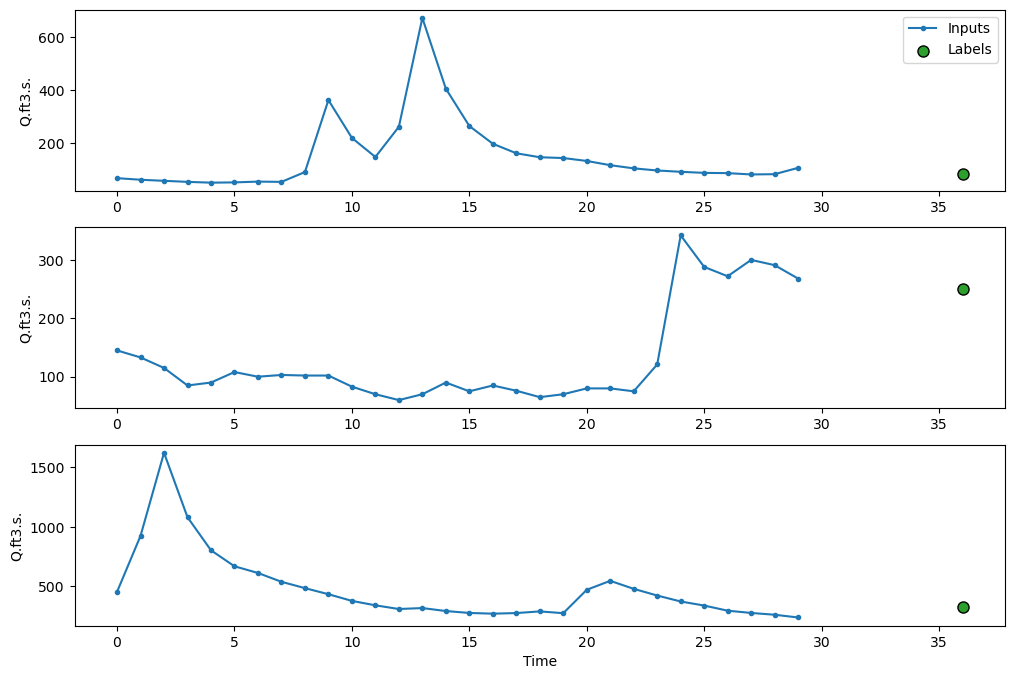

In [21]:
w.plot('Q.ft3.s.')

# Make Forecast Model

In [22]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, w, 100, 10)

In [36]:
val_perf = lstm_model.evaluate(w.val)

79/79 [==============================] - 1s 8ms/step - loss: -0.2355 - mean_absolute_error: 147.2842


In [39]:
val_perf[0]

-0.2354656606912613

# Wavelet

In [24]:
from preprocessor import make_preprocessor_function

In [25]:
tempfun = make_preprocessor_function("HUC_03_GAGEID_03488000")

In [32]:
basin_3_w = tempfun([1,1,1,1,1,1,1,1,1,1,1,1])
basin_3_w

,y_target,y_0,x1_0,x2_0,x3_0,x4_0,x5_0,x6_0,x1_W1_0,x1_V1_0,x2_W1_0,x2_V1_0,x3_W1_0,x3_V1_0,x4_W1_0,x4_V1_0,x5_W1_0,x5_V1_0,x6_W1_0,x6_V1_0
821,249,249,44582.38,0.53,361.09,20.06,8.74,1139.56,172.785,44409.595,0.265,0.265,-64.005,425.095,0.855,19.205,3.960,4.780,246.210,893.350
822,237,237,44582.38,2.91,430.29,18.95,0.19,612.60,0.000,44582.380,1.190,1.720,34.600,395.690,-0.555,19.505,-4.275,4.465,-263.480,876.080
823,215,215,44928.01,0.00,532.26,20.83,-1.87,536.26,172.815,44755.195,-1.455,1.455,50.985,481.275,0.940,19.890,-1.030,-0.840,-38.170,574.430
824,210,210,44928.01,2.74,276.81,19.92,9.56,1205.04,0.000,44928.010,1.370,1.370,-127.725,404.535,-0.455,20.375,5.715,3.845,334.390,870.650
825,202,202,44928.01,0.00,413.59,16.11,3.05,764.84,0.000,44928.010,-1.370,1.370,68.390,345.200,-1.905,18.015,-3.255,6.305,-220.100,984.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12780,451,451,34214.39,0.00,303.04,13.43,-6.20,383.82,0.000,34214.390,0.000,0.000,13.295,289.745,3.540,9.890,-0.300,-5.900,-9.070,392.890
12781,386,386,34214.39,0.00,278.05,15.35,1.32,665.95,0.000,34214.390,0.000,0.000,-12.495,290.545,0.960,14.390,3.760,-2.440,141.065,524.885
12782,392,392,34214.39,9.30,96.47,8.53,4.03,814.83,0.000,34214.390,4.650,4.650,-90.790,187.260,-3.410,11.940,1.355,2.675,74.440,740.390
12783,466,466,34214.39,6.79,159.37,6.65,-1.14,564.31,0.000,34214.390,-1.255,8.045,31.450,127.920,-0.940,7.590,-2.585,1.445,-125.260,689.570


In [34]:
basin_3_w.drop("y_0", axis=1, inplace=True)

In [35]:
basin_3_w

,y_target,x1_0,x2_0,x3_0,x4_0,x5_0,x6_0,x1_W1_0,x1_V1_0,x2_W1_0,x2_V1_0,x3_W1_0,x3_V1_0,x4_W1_0,x4_V1_0,x5_W1_0,x5_V1_0,x6_W1_0,x6_V1_0
821,249,44582.38,0.53,361.09,20.06,8.74,1139.56,172.785,44409.595,0.265,0.265,-64.005,425.095,0.855,19.205,3.960,4.780,246.210,893.350
822,237,44582.38,2.91,430.29,18.95,0.19,612.60,0.000,44582.380,1.190,1.720,34.600,395.690,-0.555,19.505,-4.275,4.465,-263.480,876.080
823,215,44928.01,0.00,532.26,20.83,-1.87,536.26,172.815,44755.195,-1.455,1.455,50.985,481.275,0.940,19.890,-1.030,-0.840,-38.170,574.430
824,210,44928.01,2.74,276.81,19.92,9.56,1205.04,0.000,44928.010,1.370,1.370,-127.725,404.535,-0.455,20.375,5.715,3.845,334.390,870.650
825,202,44928.01,0.00,413.59,16.11,3.05,764.84,0.000,44928.010,-1.370,1.370,68.390,345.200,-1.905,18.015,-3.255,6.305,-220.100,984.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12780,451,34214.39,0.00,303.04,13.43,-6.20,383.82,0.000,34214.390,0.000,0.000,13.295,289.745,3.540,9.890,-0.300,-5.900,-9.070,392.890
12781,386,34214.39,0.00,278.05,15.35,1.32,665.95,0.000,34214.390,0.000,0.000,-12.495,290.545,0.960,14.390,3.760,-2.440,141.065,524.885
12782,392,34214.39,9.30,96.47,8.53,4.03,814.83,0.000,34214.390,4.650,4.650,-90.790,187.260,-3.410,11.940,1.355,2.675,74.440,740.390
12783,466,34214.39,6.79,159.37,6.65,-1.14,564.31,0.000,34214.390,-1.255,8.045,31.450,127.920,-0.940,7.590,-2.585,1.445,-125.260,689.570
